In [1]:
import torch
import numpy as np
import cv2
import scipy

from torch import nn
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


from numpy import dot
from numpy.linalg import matrix_rank, inv
from numpy.random import permutation
from scipy.linalg import eigh
from scipy.linalg import norm as mnorm
from scipy.stats import ortho_group

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import os


import ica

from modules.util import entropyLoss, getdata, entropy
# from modules.kde import kernel_density_estimator
# import n_sphere

import random

In [6]:
a = torch.rand(100,2)
b = torch.rand(100,1)

In [7]:
cos = torch.nn.CosineSimilarity(dim=0)

In [8]:
cos(a,b)

tensor([0.7656, 0.7207])

In [9]:
F.cosine_similarity(a,b,dim=0)

tensor([0.7656, 0.7207])

In [2]:
def knn(x, y, k=3, last_only=False, discard_nearest=True, dis=0):
    """Find k_neighbors-nearest neighbor distances from y for each example in a minibatch x.
    :param x: tensor of shape [T, N]
    :param y: tensor of shape [T', N]
    :param k: the (k_neighbors+1):th nearest neighbor
    :param last_only: use only the last knn vs. all of them
    :param discard_nearest:
    :return: knn distances of shape [T, k_neighbors] or [T, 1] if last_only
    """

    if dis == 0:
        '''
        cosine similarity
        '''
        dot_p = torch.matmul(x, y.transpose(0,1))
        norm_x = torch.norm(x, dim=1).unsqueeze(1)
        norm_y = torch.norm(y, dim=1).unsqueeze(0)
        ab = torch.mm(norm_x, norm_y) + 1e-6
        distmat = 1 - dot_p/ab + 1e-6
    if dis == 1:
        dist_x = (x ** 2).sum(-1).unsqueeze(1)  # [T, 1]
        dist_y = (y ** 2).sum(-1).unsqueeze(0)  # [1, T']
        cross = - 2 * torch.mm(x, y.transpose(0, 1))  # [T, T']
        distmat = dist_x + cross + dist_y  # distance matrix between all points x, y
        distmat = torch.clamp(distmat, 1e-8, 1e+8)  # can have negatives otherwise!

    if discard_nearest:  # never use the shortest, since it can be the same point
        knn, _ = torch.topk(distmat, k + 1, largest=False)
        knn = knn[:, 1:]
    else:
        knn, _ = torch.topk(distmat, k, largest=False)

    if last_only:
        knn = knn[:, -1:]  # k_neighbors:th distance only

    return torch.sqrt(knn)


def entropy(x, k=3, eps=1e-8, last_only=False, dis=0):
    """Entropy estimator for batch x~p(x).
        :param x: prediction; shape [T, N]
        :param k:
        :return: scalar
        """
    if type(x) is np.ndarray:
        x = torch.tensor(x.astype(np.float32))

    # x = (0.5+x)/2

    nns_xx = knn(x, x, k=k, last_only=last_only, discard_nearest=True, dis=dis)

    ent = torch.log(nns_xx + eps).mean() - torch.log(torch.tensor(eps))

    return -ent

In [3]:
# def my_loss(x, k=3):
#     n, d = x.shape
#     q, rem = divmod(d, 3)
    
#     if rem == 1:
#         loss = entropy(x[:,-2:], k=k, dis=1)
#         loss += entropy(x[:,-4:-2], k=k, dis=1)
#         for i in range(q-1):
#             loss += entropy(x[:, i*3:(i+1)*3], k=k, dis=1)
#     if rem == 2:
#         loss = entropy(x[:,-2:], k=k, dis=1)
#         for i in range(q):
#             loss += entropy(x[:, i*3:(i+1)*3], k=k, dis=1)
#     else:
#         loss = 0
#         for i in range(q):
#             loss += entropy(x[:, i*3:(i+1)*3], k=k, dis=1)
            
#     return loss

# def my_loss(x, k=3):
#     n, d = x.shape

#     loss = 0
#     for i in range(d-2):
#         loss += entropy(x[:, i:i+3], k=k, dis=1)
            
#     return loss

# def my_loss(x, k=3):
#     n, d = x.shape
    
#     loss = 0
#     for i in range(d-1):
#         loss += entropy(x[:, i:], k=k, dis=1)
#     return loss

def my_loss(x, n, k=3):
    _, d = x.shape
    loss=0
    for i in range(n):
        index = random.sample(range(d),3)
        loss += entropy(x[:, index], k=k)
    return loss/n

# def my_loss(x, k=3):
#     n, d = x.shape
#     q, rem = divmod(d, 3)
    
#     loss = 0
#     for i in range(3*q):
#         index = random.sample(range(d),3)
#         loss += entropy(x[:, index], k=k, dis=1)
            
#     return loss

# def my_loss(x, k=3):
#     n, d = x.shape
#     q, rem = divmod(d, 3)
    
#     loss = 0
#     for i in range(d-2):
#         for j in range(i+1, d-1):
#             for m in range(j+1, d):
# #             index = random.sample(range(d),3)
#                 index=[i,j,m]
#                 loss += entropy(x[:, index], k=k, dis=1)
            
#     return loss

In [4]:
class infomaxICA(nn.Module):

    def __init__(self, n, bias=False):
        super(infomaxICA, self).__init__()
        self.W1 = torch.nn.Linear(n, n, bias=bias)
        with torch.no_grad():
            self.W1.weight = nn.Parameter(torch.diag(torch.ones(n)))
            if bias == True:
                self.W1.bias = nn.Parameter(torch.zeros(n))

        self.W_bn = torch.nn.BatchNorm1d(n, track_running_stats = False)
        for param in self.W_bn.parameters():
            param.requires_grad = False

        # self.weight = torch.nn.parameter.Parameter(torch.rand(1), requires_grad=True)
        self.init_weight()

    def weights_init(self, m, layer_type=nn.Linear):
        if isinstance(m, layer_type):
            nn.init.xavier_normal_(m.weight.data)

    def init_weight(self):
        for layer in [nn.Linear]:
            self.apply(lambda x: self.weights_init(x, layer_type=layer))

    def forward(self, input):
        output_w1 = self.W1(input)  
        output_w1 = self.W_bn(output_w1)
 
        return output_w1


In [5]:
file_name = os.listdir('./data')
dir_list = []
for name in file_name[0:10]:
    dir_list.append('./data/'+name)
num_of_img = len(dir_list)
# num_of_img = 3
resize = 128

array_list=[]

for img_dir in dir_list:
    image = Image.open(img_dir)
    image = np.array(ImageOps.grayscale(image))
    image = cv2.resize(image, (resize, resize))
#     image = torch.from_numpy(image).float().flatten()
    image = np.expand_dims(image.flatten(), axis=0)
    array_list.append(image)

img_concate = np.concatenate(array_list)
np.random.seed(1)

# D = np.diag(2**np.array([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7], dtype=float))

# B = ortho_group.rvs(dim=num_of_img)
# A = B @ D
# A = np.random.normal(0, 1, size=(num_of_img,num_of_img))
A = np.random.rand(num_of_img,num_of_img)
mixture = A@img_concate

print(A, img_concate.shape, sep='\n')

print('condition number:', np.linalg.cond(A))


[[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
  1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
  3.96767474e-01 5.38816734e-01]
 [4.19194514e-01 6.85219500e-01 2.04452250e-01 8.78117436e-01
  2.73875932e-02 6.70467510e-01 4.17304802e-01 5.58689828e-01
  1.40386939e-01 1.98101489e-01]
 [8.00744569e-01 9.68261576e-01 3.13424178e-01 6.92322616e-01
  8.76389152e-01 8.94606664e-01 8.50442114e-02 3.90547832e-02
  1.69830420e-01 8.78142503e-01]
 [9.83468338e-02 4.21107625e-01 9.57889530e-01 5.33165285e-01
  6.91877114e-01 3.15515631e-01 6.86500928e-01 8.34625672e-01
  1.82882773e-02 7.50144315e-01]
 [9.88861089e-01 7.48165654e-01 2.80443992e-01 7.89279328e-01
  1.03226007e-01 4.47893526e-01 9.08595503e-01 2.93614148e-01
  2.87775339e-01 1.30028572e-01]
 [1.93669579e-02 6.78835533e-01 2.11628116e-01 2.65546659e-01
  4.91573159e-01 5.33625451e-02 5.74117605e-01 1.46728575e-01
  5.89305537e-01 6.99758360e-01]
 [1.02334429e-01 4.14055988e-01 6.94400158e-01 4.14179270e

# plot of ica.ica1 output

In [6]:
# A0, r, W = ica.ica1(mixture, num_of_img, verbose=True)
# # print(w)


# plt.figure(figsize=(10,10))

# sub_shape = num_of_img

# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(r[i], r[j], '.', ms=0.1)


# %matplotlib inline

# plt.figure(figsize=(10,10))
# for i in range(num_of_img):
#     plt.subplot(num_of_img, 2, i*2+1)
#     plt.imshow(np.reshape(mixture[i], (resize,resize)), cmap='gray')
#     plt.title('mixture')
#     plt.axis('off')
    
#     plt.subplot(num_of_img, 2, i*2+2)
#     plt.imshow(np.reshape(r[i], (resize,resize)), cmap='gray')
#     plt.title('output')
#     plt.axis('off')

In [7]:
#data whitening
# minim = np.expand_dims(np.min(mixture, axis=1),1)
# maxim = np.expand_dims(np.max(mixture, axis=1),1)
# mixture = (mixture-minim)/(maxim-minim)


# IPT = x_white.copy()
# IPT = torch.from_numpy(IPT).type(torch.float32)
# IPT = torch.from_numpy(mixture).type(torch.float32)
# IPT = (IPT - IPT.mean(axis=1).unsqueeze(1))/(IPT.std(axis=1, unbiased=False).unsqueeze(1))

# IPT_white = IPT.clone()

x_white, white, dewhite = ica.pca_whiten(mixture, num_of_img)

IPT = torch.from_numpy(x_white.copy()).type(torch.float32)

# minim = torch.min(IPT, axis=1)[0].unsqueeze(1)
# maxim = torch.max(IPT, axis=1)[0].unsqueeze(1)
# IPT = (IPT-minim)/(maxim-minim)

In [8]:
mixture.shape

(10, 16384)

In [9]:
# %matplotlib inline
# plt.figure(figsize=(20,20))

# index = num_of_img

# for row in range(index):
#     for column in range(index):
#         plt.subplot(index, index, row*index + column+1)
#         plt.plot(x_white[row], x_white[column], '.', ms=0.5)

In [10]:
# %matplotlib inline
# plt.figure(figsize=(20,20))

# index = num_of_img

# for row in range(index):
#     for column in range(index):
#         plt.subplot(index, index, row*index + column+1)
#         plt.plot(x_white[row], x_white[column], '.', ms=0.5)

In [11]:
device = torch.device('cuda:0')

In [12]:
model = infomaxICA(num_of_img)

In [13]:
learning_rate = 0.0003 / np.log(num_of_img)
# learning_rate = 0.0001
batch_size = int(np.floor(np.sqrt(IPT.shape[1] / 3)))
# batch_size = int(resize*resize)
# batch_size = 1024
dataset = getdata(IPT)
sampler = SequentialSampler(dataset)
# sampler = RandomSampler(dataset)
print('the batch size is: ', batch_size)
print('the start learning rate is: ', learning_rate)
loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=batch_size)

# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=learning_rate,
                             eps=10e-4,
                             weight_decay = 1e-4,
                            )


num_epoch = 5000
scheduler = CosineAnnealingLR(optimizer, T_max = num_epoch/2)
# scheduler = OneCycleLR(optimizer, 
#                        learning_rate, 
#                        steps_per_epoch=len(loader), 
#                        epochs=num_epoch,
#                       )

# np.linalg.inv(model.W1.weight.data)

the batch size is:  73
the start learning rate is:  0.00013028834457097554


In [14]:
model = model.to(device)
IPT = IPT.to(device)

In [15]:
loss_tracker = []

In [16]:
def norm(x):
    """Computes the norm of a vector or the Frobenius norm of a
    matrix_rank
    """
    return torch.norm(torch.flatten(x))

<IPython.core.display.Javascript object>


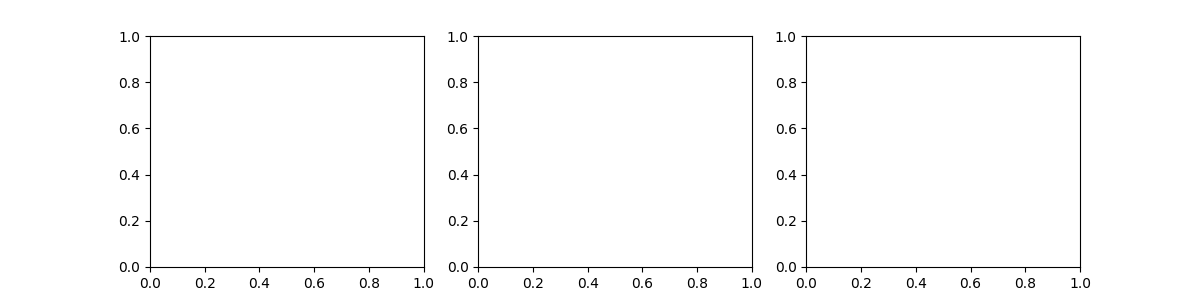

KeyboardInterrupt: 

In [17]:
%matplotlib notebook
k=3
# k = int(batch_size*0.16)

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
# ax2 = fig.add_subplot(133, projection='3d')
ax3 = fig.add_subplot(133)

# trace = []
change = 100
W_STOP = 1e-8
d_weigths = torch.zeros(num_of_img)
old_d_weights = torch.zeros([1, num_of_img])
torch_pi = torch.acos(torch.zeros(1)).item() * 2 

# for epoch in range(num_epoch):
step0 = 0
angle_delta = 0
while step0 < num_epoch and change > W_STOP:
# for i in range(1000):
    LOSS = 0
    old_weight = torch.clone(model.W1.weight.data)
    for step, ipt in enumerate(loader):
        model.zero_grad()
        ipt = ipt.to(device)
        
        opt = model.forward(ipt)
#------------------------------sphe2cartesin----------------------------------
        
#         opt = angle2cart(opt)
#         opt = spher2cart(opt)
    
#---------------------------------------------------------------
#         loss = entropyLoss(opt.permute(1,0), device=device)
#         loss = entropy(opt, k=k, dis=1)
        loss = my_loss(opt, n=num_of_img*100, k=3)
        loss.backward()
        optimizer.step()
        LOSS+=loss
    d_weigths = model.W1.weight.data - old_weight
    change = norm(d_weigths)**2
    d_weigths = d_weigths.cpu()
    if step > 2:
        angle_delta = torch.arccos(
                    torch.sum(d_weigths * old_d_weights) /
                    (norm(d_weigths) * norm(old_d_weights) + 1e-8)
                ) * 180 / torch_pi
    if angle_delta > 60:
        learning_rate = learning_rate * 0.9
        
        print('lr changed to:', learning_rate)
        
        optimizer.param_groups[0]['lr'] = learning_rate
        old_d_weights = torch.clone(d_weigths)
    elif step == 1:
        old_d_weights = torch.clone(d_weigths)
        
        
        
    LOSS = LOSS.cpu()
    loss_tracker.append(LOSS.detach().numpy()/len(loader.sampler))
    if step0 % 2 == 0:
        
        index = np.random.randint(0,num_of_img, 2)
#         index = [0,1]
        ax.clear()
        ax.plot(loss_tracker[-100:])
        fig.canvas.draw()
    
#         data = model.forward(IPT.T).cpu().detach().numpy()
        data1 = model.forward(IPT.T)
#         data2 = angle2cart(data1).cpu().detach().numpy()
#         data2 = spher2cart(data1).cpu().detach().numpy()
        data1 = data1.cpu().detach().numpy()
        data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
#         data2 = data.cpu().detach().numpy()
        ax1.clear()
        ax1.plot(data1[:, index[0]], data1[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        
#         ax2.clear()
#         ax2.scatter(data2[:,-1], data2[:,-2], data2[:,-3], c = 'r', s=0.1)

# #         ax2.set_xlim3d(-2,2)
# #         ax2.set_ylim3d(-2,2)
# #         ax2.set_zlim3d(-2,2)
#         ax2.set_xlim3d(-10,10)
#         ax2.set_ylim3d(-10,10)
#         ax2.set_zlim3d(-10,10)
        
#         fig.canvas.draw()

        ax3.clear()
        
        ax3.plot(data[:, index[0]], data[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        

    

    step0 += 1
    print(step0, angle_delta.item(), LOSS.detach().numpy()/len(loader.sampler), change.item())
    scheduler.step()

In [ ]:
%matplotlib inline
plt.plot(loss_tracker)

In [ ]:
# opt = model.forward(IPT.T).cpu()
# opt = angle2cart(opt)

# print('the eutropy of uniform:', entropy(P, k=3))
# print('the entropy of angle to cart:', entropy(opt, k=3))

In [ ]:
# model = model.cpu()
# IPT = IPT.cpu()
# data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()

In [ ]:
# data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
# data = model.forward(IPT.T).cpu().detach().numpy()


In [ ]:
# %matplotlib inline
# # plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # # plt.axis('square')
# plt.figure(figsize=(10,10))
# sub_shape = num_of_img
# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(data[:, i], data[:, j], '.', ms=1)
#         plt.axis('square')

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,5*num_of_img))
for i in range(num_of_img):
    plt.subplot(num_of_img, 3, i*3+1)
    plt.imshow(np.reshape(array_list[i], (resize,resize)), cmap='gray')
    plt.title('original')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+2)
    plt.imshow(np.reshape(x_white[i], (resize,resize)), cmap='gray')
    plt.title('mixture')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+3)
    plt.imshow(-np.reshape(data[:, i], (resize,resize)), cmap='gray')
    plt.title('output')
    plt.axis('off')

In [ ]:
# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(data2.T[:, i], data2.T[:, j], '.', ms=1)
#         plt.axis('square')

In [ ]:
# def myISI(WAr):
#     N = WAr.shape[0]
#     WAr = np.abs(WAr)
#     ISI = 0.
#     ISI += np.sum(np.sum(WAr,axis=1)/np.max(WAr,axis=1) - 1)
#     # np.max(WAr,axis=1)
#     ISI += np.sum(np.sum(WAr,axis=0)/np.max(WAr,axis=0) - 1)
#     # np.max(WAr,axis=0)
#     ISI = ISI/(2*N*(N-1))
#     return ISI

# w_mnn = model.W1.weight.data.detach().numpy()
# print('myISI(w_mnn*A)=', myISI(w_mnn*A))
# print('myISI(white*A)=', myISI(white*A))
# print('myISI(w_mnn*white)=', myISI(w_mnn*white))
# print('myISI(w_mnn*white.T)=', myISI(w_mnn*white.T))

In [18]:
mixer, b, unmixer = ica.ica1(mixture, ncomp=num_of_img, verbose=True)

Whitening data...
x_white shape: 10, 16384
Done.
Running INFOMAX-ICA ...
Beginning ICA training...
Step 59: Lrate 5.4e-06,Wchange 6.5e-07,Angle 82.22
Done.


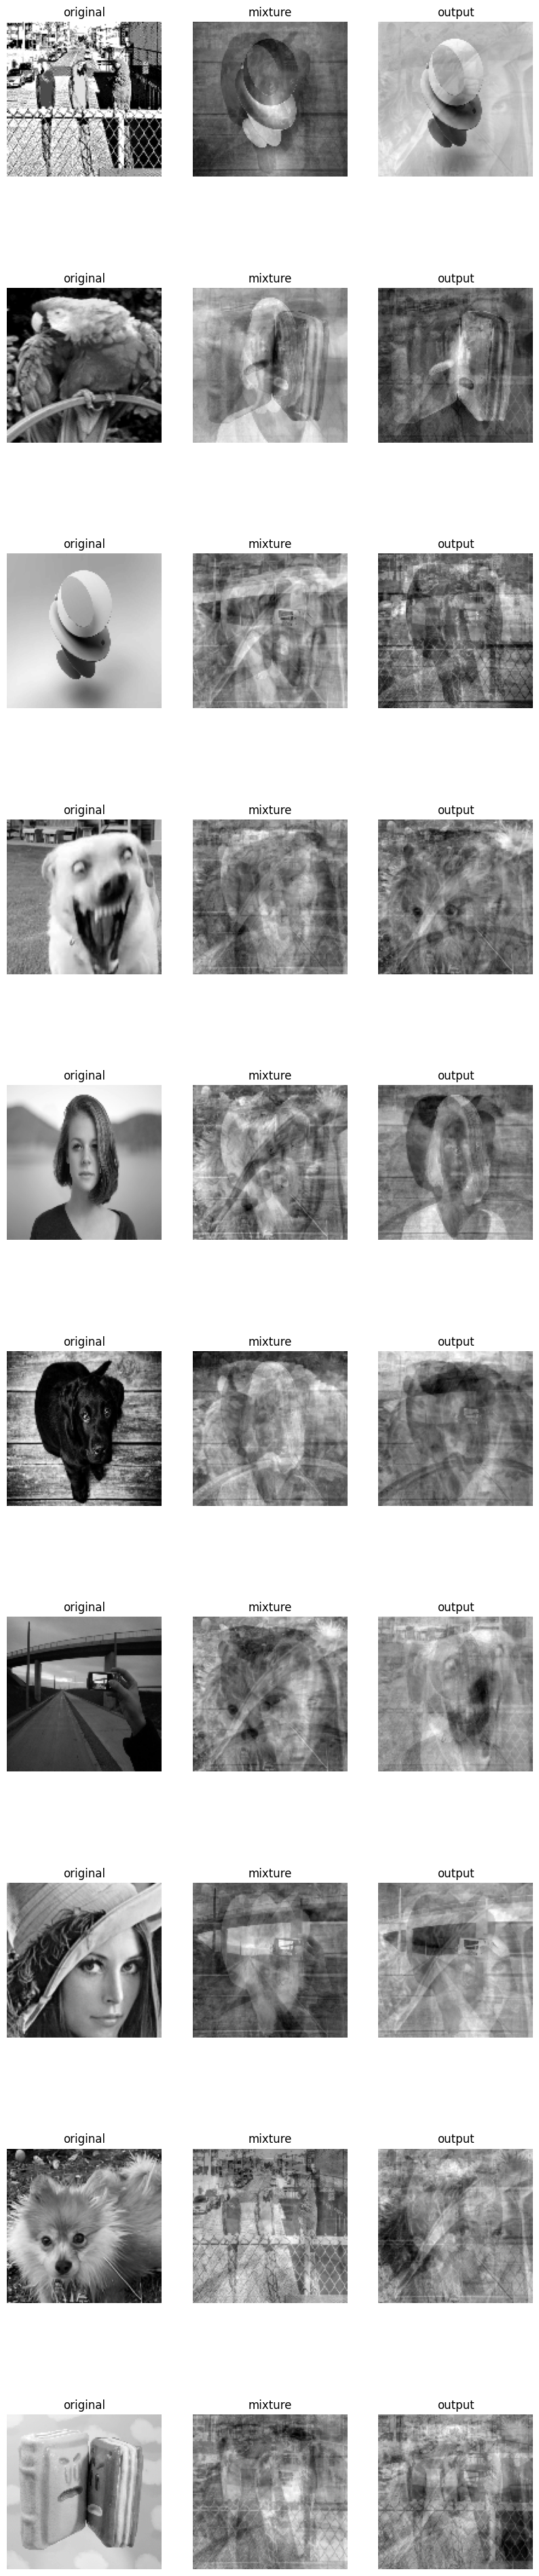

In [19]:
%matplotlib inline

plt.figure(figsize=(10,5*num_of_img))
for i in range(num_of_img):
    plt.subplot(num_of_img, 3, i*3+1)
    plt.imshow(np.reshape(array_list[i], (resize,resize)), cmap='gray')
    plt.title('original')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+2)
    plt.imshow(np.reshape(x_white[i], (resize,resize)), cmap='gray')
    plt.title('mixture')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+3)
    plt.imshow(np.reshape(-b[i], (resize,resize)), cmap='gray')
    plt.title('output')
    plt.axis('off')

In [ ]:
# model = model.cpu()
# IPT = IPT.cpu()
data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
# data = model.forward(IPT.T).cpu().detach().numpy()

In [ ]:
%matplotlib inline
# plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # plt.axis('square')
plt.figure(figsize=(10,10))
sub_shape = num_of_img
for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data[:, i], data[:, j], '.', ms=1)
        plt.axis('square')

In [ ]:
%matplotlib inline
# plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # plt.axis('square')
plt.figure(figsize=(10,10))
sub_shape = num_of_img
for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(b[i], b[j], '.', ms=1)
        plt.axis('square')

In [ ]:
b.shape

In [ ]:
data.shape

In [ ]:
map_k_i = np.corrcoef(data.T, b)
map_k_white = np.corrcoef(data.T, x_white)
map_i_white = np.corrcoef(b, x_white)

In [ ]:
plt.imshow(abs(map_k_i), cmap='gist_heat')
plt.colorbar()

In [ ]:
plt.imshow(abs(map_k_white), cmap='gist_heat')
plt.colorbar()

In [ ]:
plt.imshow(abs(map_i_white), cmap='gist_heat')

In [ ]:
plt.imshow(abs(np.corrcoef(data.T)), cmap='gist_heat')
plt.colorbar()